# Modeling Your Data - Lab

## Introduction 

In this lab you'll perform a full linear regression on the data. You'll implement the process demonstrated in the previous lesson, taking a stepwise approach to analyze and improve the model along the way.

## Objectives
You will be able to:

* Remove predictors with p-values too high and refit the model
* Examine and interpret the model results
* Split data into training and testing sets
* Fit a regression model to the data set using statsmodel library


## Build an Initial Regression Model

To start, perform a train-test split and create an initial regression model to model the `list_price` using all of your available features.

> **Note:** In order to write the model you'll have to do some tedious manipulation of your column names. Statsmodels will not allow you to have spaces, apostrophe or arithmetic symbols (+) in your column names. Preview them and refine them as you go.  
**If you receive an error such as "PatsyError: error tokenizing input (maybe an unclosed string?)" then you need to further preprocess your column names.**

In [196]:
import pandas as pd
import numpy as np 

from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [174]:
df = pd.read_csv('Lego_dataset_cleaned.csv')
print(list(df.columns)[0:10])
len(df.columns)

['piece_count', 'list_price', 'num_reviews', 'play_star_rating', 'star_rating', 'val_star_rating', 'ages_10+', 'ages_10-14', 'ages_10-16', 'ages_10-21']


103

In [176]:
#Your code here
def col_format(df):
    corrected_cols=[]
    for i in df.columns:
        i=i.replace(' ', '_')
        i=i.replace('-', '_')
        i=i.replace('+', 'plus')
        i=i.replace("'", "")
        i=i.replace('.', '')
        i=i.replace('™', '')
        i=i.replace('®', '')
        i=i.replace('½', 'half')
        corrected_cols.append(i)
    return corrected_cols
col_format(df)[:10]

['piece_count',
 'list_price',
 'num_reviews',
 'play_star_rating',
 'star_rating',
 'val_star_rating',
 'ages_10plus',
 'ages_10_14',
 'ages_10_16',
 'ages_10_21']

In [178]:
df.columns=col_format(df)
df.columns

Index(['piece_count', 'list_price', 'num_reviews', 'play_star_rating',
       'star_rating', 'val_star_rating', 'ages_10plus', 'ages_10_14',
       'ages_10_16', 'ages_10_21',
       ...
       'country_NZ', 'country_PL', 'country_PT', 'country_US',
       'review_difficulty_Average', 'review_difficulty_Challenging',
       'review_difficulty_Easy', 'review_difficulty_Very_Challenging',
       'review_difficulty_Very_Easy', 'review_difficulty_unknown'],
      dtype='object', length=103)

In [164]:
# subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),('+','plus'), ('½','half'), ('-','_')]
# def col_formatting(col):
#     for old, new in subs:
#         col = col.replace(old,new)
#     return col

# df.columns = [col_formatting(col) for col in df.columns]

In [165]:
train, test = train_test_split(df, random_state=42)

## Remove the Uninfluential Features

Based on the initial model, remove those features which do not appear to be statistically relevant and rerun the model.

In [166]:
#Your code here

predictors=list(df.drop(labels='list_price', axis=1).columns)
predictors= '+'.join(predictors)
outcome='list_price'
formula=outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     531.8
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:49:14   Log-Likelihood:                -40683.
No. Observations:                8152   AIC:                         8.156e+04
Df Residuals:                    8057   BIC:                         8.222e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           64.9906      1.837     35.388      0.000      61.391      68.591
piece_count                                         75.3039      0.918     82.073      0.000      73.505      77.102
num_reviews                                          6.8871      0.705      9.770      0.000       5.505       8.269
play_star_rating                                     4.9973      0.638      7.830      0.000       3.746       6.248
star_rating                                         -0.5237      0.721     -0.727      0.467      -1.936       0.889
val_star_rating                                     -9.1327      0.651    -14.036      0.000     -10.408      -7.857
ages_10plus                                        124.4711      6.968     17.863      0.000     110.812     138.131
ages_10_14                                         -23.3215      9.360     -2.492      0.013     -41.670      -4.973
ages_10_16                                         -11.7835      4.103     -2.872      0.004     -19.825      -3.742
ages_10_21                                          54.4662      7.766      7.013      0.000      39.242      69.691
ages_11_16                                         -14.3253      6.009     -2.384      0.017     -26.104      -2.546
ages_12plus                                         71.6838      5.968     12.012      0.000      59.985      83.382
ages_12_16                                         -47.5989      6.902     -6.897      0.000     -61.128     -34.070
ages_14plus                                         20.6740      4.151      4.980      0.000      12.537      28.811
ages_16plus                                         30.7075      6.345      4.839      0.000      18.269      43.146
ages_1half_3                                        -9.1521      2.451     -3.734      0.000     -13.957      -4.347
ages_1half_5                                        -4.8670      3.216     -1.514      0.130     -11.171       1.437
ages_2_5                                            15.0620      1.743      8.641      0.000      11.645      18.479
ages_4plus                                         -20.4673      6.282     -3.258      0.001     -32.782      -8.153
ages_4_7                                            -6.3293      3.182     -1.989      0.047     -12.566      -0.093
ages_4_99                                           -2.0819      3.586     -0.581      0.562      -9.111       4.947
ages_5plus                                          -9.8430      3.048     -3.229      0.001     -15.818      -3.868
ages_5_12                                          -35.9125      3.206    -11.202      0.000     -42.197     -29.628
ages_5_8                                 

> **Comment:** You should see that the model performance is identical. Additionally, observe that there are further features which have been identified as unimpactful. Continue to refine the model accordingly.

In [167]:
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x = list(p_table[p_table['P>|t|']<0.05].index)
x.remove('Intercept')

In [168]:
#Refit model with subset features
predictors = '+'.join(x)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     713.7
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:49:21   Log-Likelihood:                -40696.
No. Observations:                8152   AIC:                         8.153e+04
Df Residuals:                    8081   BIC:                         8.203e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           65.0193      2.386     27.246      0.000      60.341      69.697
piece_count                                         75.6544      0.895     84.487      0.000      73.899      77.410
num_reviews                                          6.7649      0.690      9.807      0.000       5.413       8.117
play_star_rating                                     4.7652      0.535      8.899      0.000       3.716       5.815
val_star_rating                                     -9.2197      0.510    -18.069      0.000     -10.220      -8.219
ages_10plus                                        118.5652      5.301     22.365      0.000     108.173     128.957
ages_10_14                                         -17.6164      9.857     -1.787      0.074     -36.939       1.706
ages_10_16                                          -7.1092      4.303     -1.652      0.099     -15.545       1.326
ages_10_21                                          44.7782      3.825     11.707      0.000      37.280      52.276
ages_11_16                                         -10.5977      6.096     -1.738      0.082     -22.548       1.353
ages_12plus                                         72.0199      6.617     10.884      0.000      59.049      84.991
ages_12_16                                         -41.2783      7.386     -5.588      0.000     -55.758     -26.799
ages_14plus                                         25.6741      5.006      5.129      0.000      15.861      35.487
ages_16plus                                         34.1094      7.190      4.744      0.000      20.015      48.204
ages_1half_3                                        -3.3589      3.599     -0.933      0.351     -10.413       3.695
ages_2_5                                            20.4106      2.707      7.539      0.000      15.104      25.717
ages_4plus                                         -19.2940      9.574     -2.015      0.044     -38.062      -0.526
ages_4_7                                            -2.0253      2.839     -0.713      0.476      -7.591       3.540
ages_5plus                                          -8.4455      3.113     -2.713      0.007     -14.549      -2.342
ages_5_12                                          -29.7754      3.253     -9.154      0.000     -36.152     -23.399
ages_6plus                                         -22.6726      5.775     -3.926      0.000     -33.993     -11.352
ages_6_12                                          -16.3522      2.578     -6.344      0.000     -21.405     -11.299
ages_7_12                                          -14.9827      2.846     -5.264      0.000     -20.562      -9.404
ages_7_14                                

In [172]:
#Extract the p-value table from the summary and use it to subset our features
summary = model.summary()

p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x = list(p_table[p_table['P>|t|']<0.05].index)
x.remove('Intercept')
p_table.head()

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,63.1875,1.221,51.738,0.0,60.793,65.582
piece_count,75.0700,0.812,92.495,0.0,73.479,76.661
num_reviews,6.7314,0.685,9.823,0.0,5.388,8.075
play_star_rating,4.9513,0.528,9.369,0.0,3.915,5.987
val_star_rating,-9.3082,0.503,-18.493,0.0,-10.295,-8.322


In [173]:
#Refit model with subset features
predictors = '+'.join(x)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     940.2
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:51:43   Log-Likelihood:                -40712.
No. Observations:                8152   AIC:                         8.153e+04
Df Residuals:                    8098   BIC:                         8.191e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           64.2069      1.179     54.444      0.000      61.895      66.519
piece_count                                         75.0582      0.812     92.441      0.000      73.467      76.650
num_reviews                                          6.5281      0.675      9.676      0.000       5.206       7.851
play_star_rating                                     5.0012      0.528      9.475      0.000       3.966       6.036
val_star_rating                                     -9.2937      0.504    -18.455      0.000     -10.281      -8.307
ages_10plus                                        122.6237      4.889     25.082      0.000     113.040     132.207
ages_10_21                                          47.1557      3.300     14.289      0.000      40.687      53.625
ages_12plus                                         77.6880      6.130     12.674      0.000      65.672      89.704
ages_12_16                                         -35.4626      6.855     -5.174      0.000     -48.899     -22.026
ages_14plus                                         34.4122      3.942      8.730      0.000      26.685      42.139
ages_16plus                                         43.0252      6.196      6.944      0.000      30.879      55.172
ages_2_5                                            22.8718      1.849     12.369      0.000      19.247      26.497
ages_4plus                                         -17.8700      9.559     -1.869      0.062     -36.608       0.868
ages_5plus                                          -7.1787      2.962     -2.424      0.015     -12.985      -1.373
ages_5_12                                          -26.5551      2.618    -10.145      0.000     -31.686     -21.424
ages_6plus                                         -19.5469      5.431     -3.599      0.000     -30.193      -8.901
ages_6_12                                          -12.5759      1.577     -7.972      0.000     -15.668      -9.484
ages_7_12                                          -11.8626      1.974     -6.008      0.000     -15.733      -7.992
ages_7_14                                           -8.2554      1.683     -4.906      0.000     -11.554      -4.957
ages_8plus                                          15.5008      4.542      3.413      0.001       6.597      24.404
ages_8_12                                          -12.4404      2.520     -4.937      0.000     -17.380      -7.500
ages_8_14                                           -6.3559      1.661     -3.826      0.000      -9.612      -3.099
ages_9plus                                         108.5547     11.551      9.398      0.000      85.912     131.197
ages_9_12                                

## Investigate Multicollinearity

There are still a lot of features in the current model! Chances are there are some strong multicollinearity issues. Begin to investigate the extend of this problem.

In [181]:
#Your code here
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[x]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x, vif))[:5]

[('piece_count', 4.006539639949977),
 ('num_reviews', 2.7550745964890297),
 ('play_star_rating', 1.7640944699284888),
 ('val_star_rating', 1.5857725515618972),
 ('ages_10plus', 7.026923352548371)]

## Perform Another Round of Feature Selection

Once again, subset your features based on your findings above. Then rerun the model once again.

In [183]:
#Your code here
vif_scores = list(zip(x, vif))
x = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

54 72


In [185]:
predictors = '+'.join(x)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     958.1
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        17:15:04   Log-Likelihood:                -41067.
No. Observations:                8152   AIC:                         8.223e+04
Df Residuals:                    8104   BIC:                         8.257e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           65.6735      1.058     62.054      0.000      63.599      67.748
piece_count                                         77.4954      0.677    114.484      0.000      76.168      78.822
num_reviews                                          5.1534      0.652      7.908      0.000       3.876       6.431
play_star_rating                                     5.7988      0.504     11.516      0.000       4.812       6.786
val_star_rating                                    -10.7136      0.504    -21.268      0.000     -11.701      -9.726
ages_10_21                                          46.1357      3.406     13.546      0.000      39.459      52.812
ages_12_16                                         -46.0483      6.951     -6.625      0.000     -59.673     -32.423
ages_14plus                                         15.6882      3.629      4.322      0.000       8.574      22.803
ages_2_5                                            22.4344      1.839     12.197      0.000      18.829      26.040
ages_4plus                                          -9.5821      9.909     -0.967      0.334     -29.006       9.842
ages_5_12                                          -27.7672      2.671    -10.395      0.000     -33.004     -22.531
ages_6plus                                         -21.8240      5.641     -3.869      0.000     -32.882     -10.766
ages_6_12                                          -15.0033      1.563     -9.598      0.000     -18.068     -11.939
ages_7_12                                          -13.4268      2.003     -6.703      0.000     -17.353      -9.500
ages_7_14                                           -9.9556      1.684     -5.911      0.000     -13.257      -6.654
ages_8plus                                           4.1399      4.638      0.893      0.372      -4.952      13.232
ages_8_12                                          -14.5728      2.560     -5.692      0.000     -19.592      -9.554
ages_8_14                                           -9.0571      1.684     -5.380      0.000     -12.357      -5.757
ages_9plus                                          22.9840     11.370      2.021      0.043       0.695      45.273
ages_9_12                                          -25.5318      6.431     -3.970      0.000     -38.137     -12.926
theme_name_BOOST                                    87.9776      9.927      8.862      0.000      68.518     107.438
theme_name_Blues_Helicopter_Pursuit                 21.4497      9.012      2.380      0.017       3.783      39.116
theme_name_Carnotaurus_Gyrosphere_Escape            45.5332     10.547      4.317      0.000      24.859      66.207
theme_name_City                          

## Check the Normality Assumption

Check whether the normality assumption holds for your model.

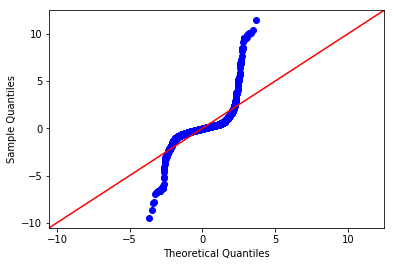

In [189]:
# Your code here
import statsmodels.api as sm
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)


## Check Homoscedasticity Assumption

Check whether the model's errors are indeed homoscedastic or if they violate this principle and display heteroscedasticity.

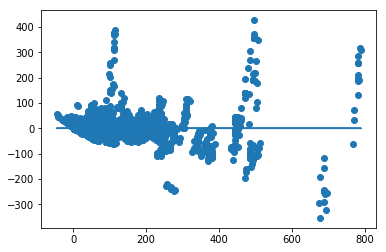

In [193]:
#Your code here
plt.scatter(model.predict(train[x]), model.resid)
plt.plot(model.predict(train[x]), [0 for i in range(len(train))])

> **Comment:** This displays a fairly pronounced 'funnel' shape: errors appear to increase as the list_price increases. This doesn't bode well for our model. Subsetting the data to remove outliers and confiding the model to this restricted domain may be necessary. A log transformation or something equivalent may also be appropriate.

## Make Additional Refinements

From here, make additional refinements to your model based on the above analysis. As you progress, continue to go back and check the assumptions for the updated model. Be sure to attempt at least 2 additional model refinements.

> **Comment:** Based on the above plots, it seems as though outliers are having a substantial impact on the model. As such, removing outliers may be appropriate. Investigating the impact of a log transformation is also worthwhile.

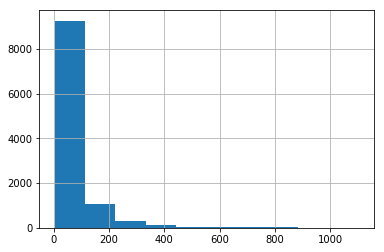

In [194]:
#Your code here
df.list_price.hist()


In [ ]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.list_price.quantile(q=q)))


In [198]:
orig_tot = len(df)
df = df[df.list_price < 450] #Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)
df.list_price = df.list_price.map(np.log) #Applying a log transformation
train, test = train_test_split(df)

#Refit model with subset features
predictors = '+'.join(x)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

Percent removed: 0.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     354.5
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        17:19:28   Log-Likelihood:                 3994.1
No. Observations:                8067   AIC:                            -7892.
Df Residuals:                    8019   BIC:                            -7556.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            1.1861      0.004    281.410      0.000       1.178       1.194
piece_count                                          0.1567      0.003     50.053      0.000       0.151       0.163
num_reviews                                         -0.0005      0.003     -0.196      0.845      -0.006       0.005
play_star_rating                                     0.0274      0.002     13.830      0.000       0.024       0.031
val_star_rating                                     -0.0400      0.002    -20.480      0.000      -0.044      -0.036
ages_10_21                                           0.2063      0.014     15.277      0.000       0.180       0.233
ages_12_16                                          -0.0688      0.029     -2.410      0.016      -0.125      -0.013
ages_14plus                                          0.0603      0.015      3.961      0.000       0.030       0.090
ages_2_5                                             0.1558      0.007     21.342      0.000       0.142       0.170
ages_4plus                                          -0.8150      0.038    -21.244      0.000      -0.890      -0.740
ages_5_12                                           -0.1846      0.010    -17.652      0.000      -0.205      -0.164
ages_6plus                                          -0.2651      0.023    -11.753      0.000      -0.309      -0.221
ages_6_12                                           -0.0309      0.006     -5.010      0.000      -0.043      -0.019
ages_7_12                                            0.0470      0.008      5.945      0.000       0.031       0.062
ages_7_14                                            0.0305      0.007      4.512      0.000       0.017       0.044
ages_8plus                                           0.1776      0.017     10.202      0.000       0.143       0.212
ages_8_12                                            0.0720      0.010      6.897      0.000       0.052       0.093
ages_8_14                                            0.0913      0.007     13.683      0.000       0.078       0.104
ages_9plus                                           0.0861      0.040      2.135      0.033       0.007       0.165
ages_9_12                                            0.1227      0.026      4.694      0.000       0.071       0.174
theme_name_BOOST                                     0.2022      0.037      5.458      0.000       0.130       0.275
theme_name_Blues_Helicopter_Pursuit                  0.2061      0.035      5.935      0.000       0.138       0.274
theme_name_Carnotaurus_Gyrosphere_Escape             0.2863      0.040      7.113      0.000       0.207       0.365
theme_name_City                          

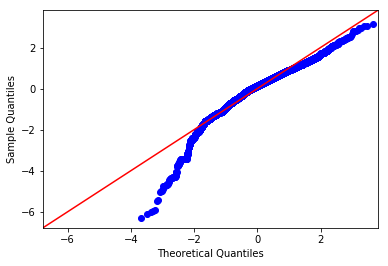

In [199]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)


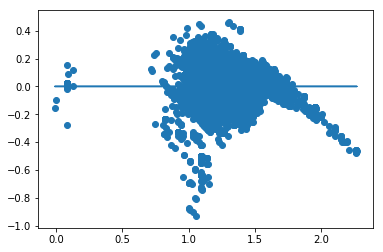

In [200]:
# Comment: There is still a clear underestimate now by the model as the log transformed 
# list price increases, but the model is much improved. Further subsetting is potentially warranted.
plt.scatter(model.predict(train[x]), model.resid)
plt.plot(model.predict(train[x]), [0 for i in range(len(train))])

## Summary

Well done! As you can see, regression can be a challenging task that requires you to make decisions along the way, try alternative approaches and make ongoing refinements. These choices depend on the context and specific use cases. 